# 🌡 Physical Calculations

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import parmesan

### 📤 Read Data

`bme280.csv` contains data from a [Bosch BME280](https://www.bosch-sensortec.com/products/environmental-sensors/humidity-sensors-bme280/) sensor.

In [ ]:
data = pd.read_csv("bme280.csv", parse_dates=["datetime"], index_col=0)
data.head()

This is what the data looks like:

In [ ]:
fig, axes = plt.subplots(ncols=3)
for (column, values), ax in zip(data.items(), axes):
    values.plot(ax=ax)
    ax.set_title(column)
fig.tight_layout()
fig.autofmt_xdate()

### 🔎 Finding the PARMESAN function

Let's calculate the potential temperature. We can use the `potential_temperature`-function for this. Use the search function of [the documentation](https://tue-umphy.gitlab.io/software/parmesan) to see how to use that function. You should see something like this, your mileage may vary:

| Searching for `potential temperature`|
|--------------------------------------|
| 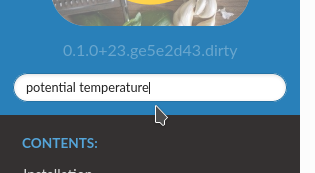 |

| Search Results for  `potential temperature`          |
|------------------------------------------------------|
| 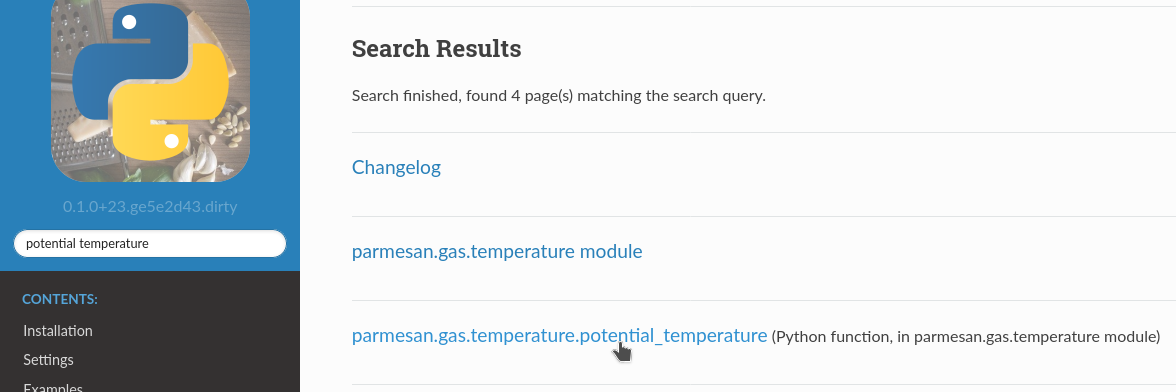 |

| Documentation for `potential_temperature()` |
|---------------------------------------------|
|      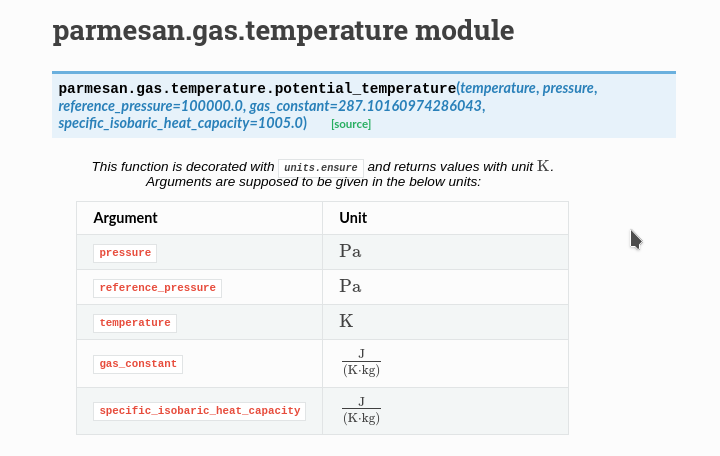 |

Now that we know how the function works, let's use it:

In [ ]:
from parmesan.gas.temperature import potential_temperature

Our data is not in the required units. One possibility is to convert the values by hand:

In [ ]:
# 🚫 ⚠️ BAD DON'T DO THIS ⚠️ 🚫
potential_temperature(
    temperature=data.temperature + 273.15,  # turn °C to Kelvin
    pressure=data.pressure * 100,  # hPa to Pa
)

However manual conversion can go wrong quickly. It is more elegant to directly supply the proper [pint](https://pint.readthedocs.io/en/stable/)-unit to our data: 

### ➕ Adding Units To DataFrame

PARMESAN has support for [pint-pandas](https://github.com/hgrecco/pint-pandas), which can be used to attach units to dataframe columns (see the [pint documentation](https://pint.readthedocs.io/en/stable/index.html) for available units. `PARMESAN` adds a couple new ones like `percent`.): 

In [ ]:
data["humidity"] = data["humidity"].astype("pint[percent]")
data["temperature"] = data["temperature"].astype("pint[°C]")
data["pressure"] = data["pressure"].astype("pint[hPa]")

The units are hidden at first:

In [ ]:
data.head()

But you can display them like this:

In [ ]:
data.head().pint.dequantify()

Or like this:

In [ ]:
data.dtypes

### 🌡️ Calculating the Potential Temperature

With the units attached to the DataFrame, calculation of the potential temperature is as easy as:

In [ ]:
potential_temperature(
    temperature=data.temperature,
    pressure=data.pressure,
)

We can also directly set it as a new column:

In [ ]:
data["potential_temperature"] = potential_temperature(
    temperature=data.temperature,
    pressure=data.pressure,
)
data.head()

Apparently, it is not yet possible to directly convert a `PintArray` as returned here by `potential_temperature()`) to a specific unit (like we'd like `potential_temperature` column to be in °C here). But we can do it afterwards:

In [ ]:
data["potential_temperature"] = data["potential_temperature"].pint.to("°C")
data.pint.dequantify().head()

### 📈 Plotting with Units

> To integrate with [matplotlib](https://matplotlib.org), [pint](https://pint.readthedocs.io/) provides a `setup_matplotlib()` function, which PARMESAN invokes on import, so plotting should work seamlessly.

In [ ]:
plt.rcParams["axes.titlesize"] = "small"
fig, axes = plt.subplots(ncols=4)
for (column, values), ax in zip(data.items(), axes):
    values.plot(ax=ax)
    ax.set_title(column)
fig.tight_layout()
fig.autofmt_xdate()

Note however that when you want to plot different units into the same plot, it'll give a unit conversion error. In that case, you can temporarily strip the units again:

In [ ]:
data.pint.dequantify().plot()

### 📝 Without Attaching Units to DataFrame

When you just have a DataFrame and don't attach units to it, it is still possible to do the above:

In [ ]:
# import units from PARMESAN
from parmesan.units import units

In [ ]:
data_without_units = pd.read_csv(
    "bme280.csv", parse_dates=["datetime"], index_col=0
)
data_without_units.head()

In [ ]:
data_without_units["potential_temperature"] = potential_temperature(
    # as °C is a strange, non-multiplicative unit (unlike most units),
    # we can't just multiply units.celsius to the values. Instead we need
    # to do it like this:
    temperature=units.Quantity(
        data_without_units.temperature.values, "celsius"
    ),
    # hPa on the other hand is a normal multiplicative unit,
    # so we can just multiply it to our data:
    pressure=data_without_units.pressure.values * units.hPa,
    # Without the trailing `.magnitude` there will be a UnitStrippedWarning.
    # This is not necessary when adding the units to the DataFrame as above.
).magnitude
data_without_units.head()

> Note: We're using the plain numpy arrays `data_without_units.pressure.values` and `data_without_units.temperature.values` here instead of just  `data_without_units.temperature` and `data_without_units.pressure` because the latter are fancy pandas Series objects which for some reason can't directly have a [pint](https://pint.readthedocs.io/en/stable/)-unit multiplied to them. Oh, well...

Here (unlike above with the DataFrame with units attached) we can also directly convert the result back to °C:

In [ ]:
potential_temperature(
    temperature=units.Quantity(
        data_without_units.temperature.values, "celsius"
    ),
    pressure=data_without_units.pressure.values * units.hPa,
).to("celsius")